In [21]:
import torch
from torch import nn
from d2l import torch as d2l

In [22]:
class Reshape(nn.Module):
    def forward(self, X):
        return X.view(-1,1,28,28)

In [27]:
# nn.Flatten 保留第一维，其他维度展开
net = torch.nn.Sequential(
    Reshape(), nn.Conv2d(1,8,kernel_size=3, padding=2),nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(8, 32, kernel_size=3), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(32*6*6, 256), nn.Dropout(p=0.3) , nn.ReLU(),
    nn.Linear(256, 64), nn.ReLU(),
    nn.Linear(64, 10))

In [28]:
# 可以通过这种方法来查看网络的每层的input_size和output_size
X = torch.rand(size=(2,1,28,28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([2, 1, 28, 28])
Conv2d output shape: 	 torch.Size([2, 8, 30, 30])
ReLU output shape: 	 torch.Size([2, 8, 30, 30])
AvgPool2d output shape: 	 torch.Size([2, 8, 15, 15])
Conv2d output shape: 	 torch.Size([2, 32, 13, 13])
ReLU output shape: 	 torch.Size([2, 32, 13, 13])
AvgPool2d output shape: 	 torch.Size([2, 32, 6, 6])
Flatten output shape: 	 torch.Size([2, 1152])
Linear output shape: 	 torch.Size([2, 256])
Dropout output shape: 	 torch.Size([2, 256])
ReLU output shape: 	 torch.Size([2, 256])
Linear output shape: 	 torch.Size([2, 64])
ReLU output shape: 	 torch.Size([2, 64])
Linear output shape: 	 torch.Size([2, 10])


In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X,y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [25]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.351, train acc 0.869, test acc 0.863
29361.7 examples/sec on cuda:0


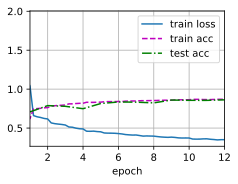

In [30]:
lr, num_epochs = 0.08, 12
train_ch6(net, train_iter, test_iter, num_epochs,
          lr, d2l.try_gpu())

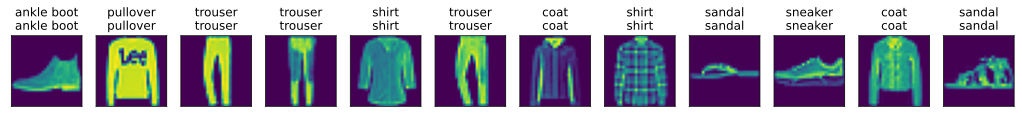

In [19]:
def predict_ch3(net, test_iter, n=12):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    net.to('cpu')
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)